***

This multilayer perceptron implementation is an exercise in understanding all operations in forward- and backpropagation processes.  Network architecture is limited to ReLU hidden layer activations, softmax output activations, vanilla SGD optimization, and MSE loss function.  Otherwise the hidden layers of the network can be designed per user specification.

***

# Dependencies

In [1]:
import numpy as np, mnist, matplotlib.pyplot as plt
#from numba import njit
#from numba.typed import List

***

In [2]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

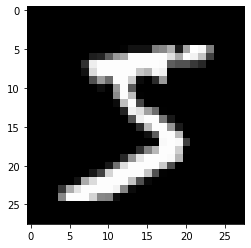

In [4]:
plt.imshow(train_images[0], 'gray');

In [5]:
class perceptron():
    def __init__(self, images, labels):
        # Assign images and labels to class attributes
        self.train_images = images
        self.train_labels = labels

        # Assert data is in correct format
        assert len(self.train_images.shape) == 3, 'Image tensor has incorrect number of axes, should be 3'
        assert self.train_images.shape[0] == self.train_labels.shape[0], 'Images and labels are of unequal length'

        # Reshape from (28,28) to (784,1) ndarray
        self.train_images = np.reshape(self.train_images,
                                       (self.train_images.shape[0],
                                        self.train_images.shape[1] * self.train_images.shape[2]))
        # Normalize images
        self.train_images = (self.train_images.astype('float32')) / 255

        # Reshape from (784,) to (784,1) ndarray and one-hot encode
        labels = np.zeros(shape=(self.train_labels.shape[0], np.max(self.train_labels)+1))
        labels[np.arange(labels.shape[0]), self.train_labels] = 1
        self.train_labels_raw = self.train_labels.copy()
        self.train_labels = labels.copy()
        self.output_width = self.train_labels.shape[1]

        self.widths = [self.train_images[0].shape[0], self.output_width]
        ## Empty lists are placeholders for input layer solely for iteration purposes
        self.weights = list([np.empty(shape=(0,0))])
        self.biases = list([np.empty(shape=(0,0)), np.random.uniform(low=-.1, high=.1, size=(self.widths[1],1))])
        self.n_layers = 2

    def add_layer(self, n_nodes):
        assert n_nodes >= self.output_width, 'Layer width less than output width'

        # Weight matrix
        self.weight_init = np.random.uniform(low=-.1, high=.1, size = (self.widths[-2]*n_nodes)) \
                                                        .reshape((self.widths[-2], n_nodes))
        self.weights.append(self.weight_init)
        self.widths.insert(-1, n_nodes)
        self.biases.insert(-1, np.random.random(size=(n_nodes, 1)))
        self.n_layers += 1

    def forward_prop(self, inputs, weights, biases, n_layers):
            # Takes image as inputs and calculates z, activations for all nodes in network
            inputs = inputs.reshape(inputs.shape[0], 1)
            self.z_f = [np.empty(shape=(0,0))]
            self.a_f = [inputs]
            for n in range(1, n_layers):
                # Dot product of weight matrix and previous layer activations, plus biases
                self.z_f.append(np.dot(weights[n].transpose(), self.a_f[n-1]) + biases[n])
                
                #If current layer is output layer, calculate softmax, else relu
                if n == n_layers-1:
                    m = np.max(self.z_f[n])
                    self.a_f.append(np.exp(self.z_f[n] - m)/sum(np.exp(self.z_f[n] - m)))
                else:
                    self.a_f.append(np.maximum(0, self.z_f[n]))
            return (self.z_f, self.a_f)

    def backprop(self, z, a, y, weights, biases, n_layers):
        a = a[::-1]
        z = z[::-1]
        y = y.reshape((y.shape[0], 1))
        w = weights[::-1]
        b = biases[::-1]
        w_g = []
        b_g = []
        self.d_a = []
        self.d_z = []
        self.d_w = []
        self.d_b = 1
        for n in range(n_layers - 1):
            if n == 0:
                self.d_a.append(2 * (a[n] - y))
                self.d_z.append((z[n] > 0) * 1)
                self.d_w.append(a[n + 1])
            else:
                self.d_a.append(np.dot(w[n - 1], (self.d_a[n-1] * self.d_z[n-1])))
                self.d_z.append((z[n] > 0) * 1)
                self.d_w.append(a[n + 1])

            # Gradient matrices are derived from the outer product of: outer((d_a[n]*d_z[n]), a[n+1])
            w_g.append(np.outer(a[n+1], (self.d_a[n]*self.d_z[n])))
            b_g.append((self.d_a[n] * self.d_z[n] * self.d_b))

        # Return the new average gradients and average biases for the entire batch
        w_g.append(np.empty(shape=(0,0)))
        b_g.append(np.empty(shape=(0,0)))
        w_g = w_g[::-1]
        b_g = b_g[::-1]
        return (w_g, b_g)
        
    def fit(self, batch_size=128, epochs=5, learning_rate=.01):

        # Initialize output layer weights
        self.weights.append(np.random.uniform(low=-.1, high=.1, size=self.widths[-2]*self.widths[-1]) \
                            .reshape((self.widths[-2], self.widths[-1])))

        num_batches = int(np.ceil(self.train_images.shape[0]/batch_size))
        
        for e in range(epochs):
            print(f'Starting epoch {e+1}/{epochs}')
            start_idx = 0
            stop_idx = batch_size

            for n in range(num_batches):
                self.batch_imgs = self.train_images[start_idx:stop_idx]
                self.batch_labels = self.train_labels[start_idx:stop_idx]
                
                start_idx = stop_idx
                stop_idx += batch_size
                
                # Reset the batch weight and bias gradients
                self.batch_w_grads = []
                self.batch_b_grads = []
                for b in range(len(self.batch_imgs)):
                    
                    ##### Feed Forward // Backpropagation for each image #####
                    
                    self.z_forward, self.a_forward = self.forward_prop(inputs = self.batch_imgs[b],
                                                                       weights = self.weights,
                                                                       biases = self.biases,
                                                                       n_layers = self.n_layers)

                    
                    self.w_grads, self.b_grads = self.backprop(z = self.z_forward,
                                                               a = self.a_forward, 
                                                               y = self.batch_labels[b], 
                                                               weights = self.weights, 
                                                               biases = self.biases, 
                                                               n_layers = self.n_layers)
                    
                    # Update average mini-batch gradients
                    if b==0:
                        self.batch_w_grads = self.w_grads.copy()
                        self.batch_b_grads = self.b_grads.copy()
                    else:
                        for layer in range(len(self.batch_w_grads)):
                            self.batch_w_grads[layer] = (self.batch_w_grads[layer]*b + self.w_grads[layer])/(b+1)
                            self.batch_b_grads[layer] = (self.batch_b_grads[layer]*b + self.b_grads[layer])/(b+1)
                
                # Update weights with mini-batch average gradients
                for w in range(len(self.weights)):
                    self.weights[w] = (self.weights[w] - (learning_rate*self.batch_w_grads[w]))
                    self.biases[w] = (self.biases[w] - (learning_rate*self.batch_b_grads[w]))

        print('Complete')
    
    def predict(self, X, y=None):
        X = X.reshape((X.shape[0], X.shape[1]*X.shape[2]))
        predictions = np.zeros(shape=(X.shape[0], 1))
        for i in range(len(X)):
            predictions[i] = np.argmax(self.forward_prop(X[i], self.weights, self.biases, self.n_layers)[1][-1])
            
        if y is not None:
            y = y.reshape((y.shape[0],1))
            accuracy = np.sum(predictions == y) / predictions.shape[0]                              
            print(f'Accuracy: {accuracy}')
        
        return predictions

***

***

In [9]:
mlp2 = perceptron(train_images, train_labels)

mlp2.add_layer(n_nodes = 16)
mlp2.add_layer(n_nodes = 32)
mlp2.add_layer(n_nodes = 16)

mlp2.fit(batch_size=32, epochs=100, learning_rate=.001)

Starting epoch 1/100
Starting epoch 2/100
Starting epoch 3/100
Starting epoch 4/100
Starting epoch 5/100
Starting epoch 6/100
Starting epoch 7/100
Starting epoch 8/100
Starting epoch 9/100
Starting epoch 10/100
Starting epoch 11/100
Starting epoch 12/100
Starting epoch 13/100
Starting epoch 14/100
Starting epoch 15/100
Starting epoch 16/100
Starting epoch 17/100
Starting epoch 18/100
Starting epoch 19/100
Starting epoch 20/100
Starting epoch 21/100
Starting epoch 22/100
Starting epoch 23/100
Starting epoch 24/100
Starting epoch 25/100
Starting epoch 26/100
Starting epoch 27/100
Starting epoch 28/100
Starting epoch 29/100
Starting epoch 30/100
Starting epoch 31/100
Starting epoch 32/100
Starting epoch 33/100
Starting epoch 34/100
Starting epoch 35/100
Starting epoch 36/100
Starting epoch 37/100
Starting epoch 38/100
Starting epoch 39/100
Starting epoch 40/100
Starting epoch 41/100
Starting epoch 42/100
Starting epoch 43/100
Starting epoch 44/100
Starting epoch 45/100
Starting epoch 46/1

In [10]:
preds = mlp2.predict(train_images, train_labels)

Accuracy: 0.7841


***

In [65]:
mlp = perceptron(train_images, train_labels)

mlp.add_layer(n_nodes = 16)
mlp.add_layer(n_nodes = 16)
mlp.add_layer(n_nodes = 16)

mlp.fit(batch_size=64, epochs=1000, learning_rate=.001)

Starting epoch 1/1000
Starting epoch 2/1000
Starting epoch 3/1000
Starting epoch 4/1000
Starting epoch 5/1000
Starting epoch 6/1000
Starting epoch 7/1000
Starting epoch 8/1000
Starting epoch 9/1000
Starting epoch 10/1000
Starting epoch 11/1000
Starting epoch 12/1000
Starting epoch 13/1000
Starting epoch 14/1000
Starting epoch 15/1000
Starting epoch 16/1000
Starting epoch 17/1000
Starting epoch 18/1000
Starting epoch 19/1000
Starting epoch 20/1000
Starting epoch 21/1000
Starting epoch 22/1000
Starting epoch 23/1000
Starting epoch 24/1000
Starting epoch 25/1000
Starting epoch 26/1000
Starting epoch 27/1000
Starting epoch 28/1000
Starting epoch 29/1000
Starting epoch 30/1000
Starting epoch 31/1000
Starting epoch 32/1000
Starting epoch 33/1000
Starting epoch 34/1000
Starting epoch 35/1000
Starting epoch 36/1000
Starting epoch 37/1000
Starting epoch 38/1000
Starting epoch 39/1000
Starting epoch 40/1000
Starting epoch 41/1000
Starting epoch 42/1000
Starting epoch 43/1000
Starting epoch 44/10

Starting epoch 347/1000
Starting epoch 348/1000
Starting epoch 349/1000
Starting epoch 350/1000
Starting epoch 351/1000
Starting epoch 352/1000
Starting epoch 353/1000
Starting epoch 354/1000
Starting epoch 355/1000
Starting epoch 356/1000
Starting epoch 357/1000
Starting epoch 358/1000
Starting epoch 359/1000
Starting epoch 360/1000
Starting epoch 361/1000
Starting epoch 362/1000
Starting epoch 363/1000
Starting epoch 364/1000
Starting epoch 365/1000
Starting epoch 366/1000
Starting epoch 367/1000
Starting epoch 368/1000
Starting epoch 369/1000
Starting epoch 370/1000
Starting epoch 371/1000
Starting epoch 372/1000
Starting epoch 373/1000
Starting epoch 374/1000
Starting epoch 375/1000
Starting epoch 376/1000
Starting epoch 377/1000
Starting epoch 378/1000
Starting epoch 379/1000
Starting epoch 380/1000
Starting epoch 381/1000
Starting epoch 382/1000
Starting epoch 383/1000
Starting epoch 384/1000
Starting epoch 385/1000
Starting epoch 386/1000
Starting epoch 387/1000
Starting epoch 3

Starting epoch 689/1000
Starting epoch 690/1000
Starting epoch 691/1000
Starting epoch 692/1000
Starting epoch 693/1000
Starting epoch 694/1000
Starting epoch 695/1000
Starting epoch 696/1000
Starting epoch 697/1000
Starting epoch 698/1000
Starting epoch 699/1000
Starting epoch 700/1000
Starting epoch 701/1000
Starting epoch 702/1000
Starting epoch 703/1000
Starting epoch 704/1000
Starting epoch 705/1000
Starting epoch 706/1000
Starting epoch 707/1000
Starting epoch 708/1000
Starting epoch 709/1000
Starting epoch 710/1000
Starting epoch 711/1000
Starting epoch 712/1000
Starting epoch 713/1000
Starting epoch 714/1000
Starting epoch 715/1000
Starting epoch 716/1000
Starting epoch 717/1000
Starting epoch 718/1000
Starting epoch 719/1000
Starting epoch 720/1000
Starting epoch 721/1000
Starting epoch 722/1000
Starting epoch 723/1000
Starting epoch 724/1000
Starting epoch 725/1000
Starting epoch 726/1000
Starting epoch 727/1000
Starting epoch 728/1000
Starting epoch 729/1000
Starting epoch 7

In [66]:
test_preds = mlp.predict(test_images, test_labels)

Accuracy: 0.8656


In [67]:
import os
os.chdir('C:\\Users\\Jon\\OneDrive\\School\\Capstone\\Exercises')
import pandas as pd
pd.to_pickle(mlp, 'mlp_trained.pkl')